In [ ]:
"""
 - Selecting the model '2c.#'s' -------------------------------------------------------------------------------------------------------------------
 Model experimentation was conducted to determine the desire model within these comment I'll provided top-view explanation of the specific hyperparameters 
 were tested. The range of experimentation was limited in scope but deemed necessary to avoid confusion regarding the new state of the model. Although the
 range was small, it provided the necessary direction to decide on the next set of model experimentation. 
 Determination of these factor were determine by these factors:
      - Values of the training accuracy/loss and validation accuracy/loss and observed the graph
      - Examine the stability, convergence, and level of overfitting/underfitting of the model with the new changes

2c.1
    - baseline select is rmsProp
    - Testing other optimizers adam
    Result validation loss is plateu and training loss is increase
    - Testing SGD
    Result unstable training/validation accruacy
    keeping rmsProp

2c.2
     - Increase the complexity of the architecture 
        - layer1 outchannel 64
        - layer2 128
        - layer3 129
        - fc1 128
        - fc2 128
    Validation loss and training loss closer
    - added dropout
        - fc2 dropout .3
    result validation loss increasing indicating overfitting, while training loss decreasing suggesting bias
    - added nested conv2d layer
        - layer2 128
    result validation loss increasing more, however the validation loss near zero

2c.3
    - Adding simple data augmentation reduce complexity architecture
        -  randomflip 29 degree
        - random RandomHorizontalFlip 
        - layer3 removed entirely
        - layer1 32
        - layer2 64
    Result Gap of validation loss is significaintly improved and training loss increase



2C.4  *** Model select show the best result of training/valdiation loss and with test accracy of 51.2%
    - Adjusting complexity and dropout
        - layer1 dropout and added conv2d
            64, 64
        - layer2 added dropout
            128,128
        -fc1: 64 added dropout
    result an stable convergence and performing well 100 epoch
 ************************************************************************************************************************
       
    result convergence training loss improve but validation loss is accelerating result overfitting

2C.5
    - Adjusting complexity
        - layer2 nested conv2d removed
        - layer2 512
        - fc1 256
   Gap reintroduce overfitting occur

2C.6
    -  layer1 128
    - layer2 256
    gap validation loss greatly increase bias of unseen data

2c.8
    - weight decay added 1e-4
   gap balidation/train is slightly improve

"""

In [227]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import ray
from ray import tune, train


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Find the CIFAR-100 

In [236]:
# for this model decide 
# Gathering the datasets CIFAR100 conveniently through the torchvision.datasets library
# stil pervious function work I only did this to do data argumentation changes quicker
cifar100_train = dsets.CIFAR100(root='CIFAR100/', train=True, transform=transforms.ToTensor(), download=True)
cifar100_test = dsets.CIFAR100(root='CIFAR100/', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


## Observe that there are 500 training images and 100 testing images for each class in the CIFAR-100 datasett

In [229]:
# Check the number of images in each category
train_classes = cifar100_train.class_to_idx
test_classes = cifar100_test.class_to_idx

# Count the number of training and test images for each class
from collections import Counter

train_counter = Counter(cifar100_train.targets)
test_counter = Counter(cifar100_test.targets)

# Print out the details
print("Training images per class:")
for class_idx in sorted(train_classes.values()):
    class_name = list(train_classes.keys())[list(train_classes.values()).index(class_idx)]
    print(f"({class_name}: {train_counter[class_idx]} images", end=') ')

print("\nTesting images per class:")
for class_idx in sorted(test_classes.values()):
    class_name = list(test_classes.keys())[list(test_classes.values()).index(class_idx)]
    print(f"({class_name}: {test_counter[class_idx]} images", end=')' )

# Check for classes
print("\nNumber of classes:", len(cifar100_train.classes))


Training images per class:
(apple: 500 images) (aquarium_fish: 500 images) (baby: 500 images) (bear: 500 images) (beaver: 500 images) (bed: 500 images) (bee: 500 images) (beetle: 500 images) (bicycle: 500 images) (bottle: 500 images) (bowl: 500 images) (boy: 500 images) (bridge: 500 images) (bus: 500 images) (butterfly: 500 images) (camel: 500 images) (can: 500 images) (castle: 500 images) (caterpillar: 500 images) (cattle: 500 images) (chair: 500 images) (chimpanzee: 500 images) (clock: 500 images) (cloud: 500 images) (cockroach: 500 images) (couch: 500 images) (crab: 500 images) (crocodile: 500 images) (cup: 500 images) (dinosaur: 500 images) (dolphin: 500 images) (elephant: 500 images) (flatfish: 500 images) (forest: 500 images) (fox: 500 images) (girl: 500 images) (hamster: 500 images) (house: 500 images) (kangaroo: 500 images) (keyboard: 500 images) (lamp: 500 images) (lawn_mower: 500 images) (leopard: 500 images) (lion: 500 images) (lizard: 500 images) (lobster: 500 images) (man:

In [230]:
# Checking each of the fine labels
print(cifar100_train.classes)
print(cifar100_train[0])
print(cifar100_train.data.shape)
print(cifar100_test.data.shape)
print(type(cifar100_train))
# checking the dimensions of cifar100 training and test sets

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

(32, 32, 3)


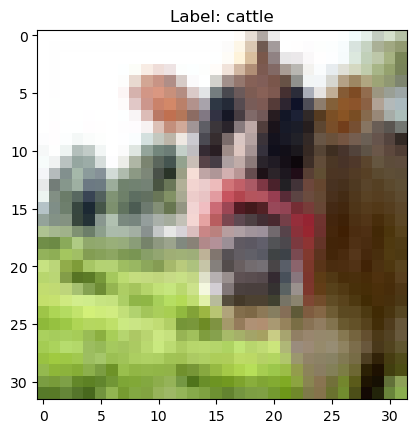

In [231]:
# Get the first image and its label
img, lab = cifar100_train[0]
# Transpose the image shape from (C, H, W) to (H, W, C) for plotting
img = img.numpy().transpose(1, 2, 0)
print(img.shape)
# Plot the image
plt.imshow(img)
plt.title(f'Label: {cifar100_train.classes[lab]}')
plt.show()

## 2a.Dataset Division dividing dataset into two parts: a sub-training set and a validation set


In [232]:
# Total size of the data training set is divide by 1/5
num_validate = int(len(cifar100_train)/5)
print(len(cifar100_train))
# 4/5 size of subtraning 
num_train = len(cifar100_train) - num_validate
print(f'num_train: {num_train}')
print(f'num_validate: {num_validate}')
# Using random_split it will be Allocate randomly 1/5 Allocate randomly training dataset to serve as the validation set
subtrain_dataset, validation_dataset = random_split(cifar100_train, [num_train, num_validate])

50000
num_train: 40000
num_validate: 10000


In [92]:
def train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs):
    # Create data loaders for the training and validation sets
    subtrain_loader = DataLoader(subtrain_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    tr_acc, tr_loss = [], []
    
    val_acc, val_loss = [], []
    best_val_loss = float('inf')
    early_stop = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in subtrain_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Calculate predictions for train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_accuracy = correct_train / total_train
        tr_acc.append(train_accuracy)
        train_loss = running_loss / len(subtrain_loader)
        tr_loss.append(train_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
        # Validation loop
        model.eval()
        validation_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        validation_loss /= len(validation_loader)
        val_loss.append(validation_loss)
        validation_accuracy =  correct / total
        val_acc.append(validation_accuracy)

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save(model.state_dict(), 'Simple_2_layer_model_best_parameters.pth')
            early_stop = 0
        else:
            early_stop += 1
            if early_stop >= 10:
                print(f'Early stopping on epoch {epoch}/{num_epochs}')
                torch.save(model.state_dict(), 'Simple_2_layer_latest_parameters.pth')
                break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')  
    print('Training Completed')
    return tr_acc, tr_loss, val_acc, val_loss



def test_model(model,test_loader):
    #model = model.to(device)
    model.eval()

    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * (correct / total)
    print(f'Test Accuracy: {test_accuracy:.4f}%')
    

def plot_model(tr_acc, tr_loss, val_acc, val_loss):
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## 2c.1 Model Experimentation. Let begin with an simple 2-layer CNN structure

In [21]:
# The first version of this CNN will contain 3 CNN layers within each of these layers will contain an activation of ReLu and 
# Max pooling to downsampling size factor of two to hopefully reduce computational
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 32 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 32/2 = 16 width, height
        )
        # Input: 16x32x32
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 16/2 = 8x8 channels 64 
        )
        # Input: 8x8x64
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            # ((8 - 3 + 2(1) / 1) + 1 = 8x8  channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4x4 channels 64
        )
        
        self.fc1 = nn.Sequential(
            # input size 64*8*8 = 1024
            nn.Linear(in_features=64 * 4 * 4, out_features=64),  
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=64, out_features=100)
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [80]:
test_loader = DataLoader(cifar100_test, batch_size=batch_size, shuffle=False)

In [84]:
batch_size = 64
num_epochs = 100

In [76]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [77]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 0/200, Training Loss: 4.3857, Training Accuracy: 0.0357
Epoch 0/200, Validation Loss: 4.1757, Validation Accuracy: 0.0609
Epoch 1/200, Training Loss: 4.0678, Training Accuracy: 0.0789
Epoch 1/200, Validation Loss: 3.9979, Validation Accuracy: 0.0867
Epoch 2/200, Training Loss: 3.9401, Training Accuracy: 0.0986
Epoch 2/200, Validation Loss: 3.8897, Validation Accuracy: 0.1126
Epoch 3/200, Training Loss: 3.8496, Training Accuracy: 0.1157
Epoch 3/200, Validation Loss: 3.8296, Validation Accuracy: 0.1222
Epoch 4/200, Training Loss: 3.7713, Training Accuracy: 0.1284
Epoch 4/200, Validation Loss: 3.7470, Validation Accuracy: 0.1327
Epoch 5/200, Training Loss: 3.7024, Training Accuracy: 0.1409
Epoch 5/200, Validation Loss: 3.6935, Validation Accuracy: 0.1455
Epoch 6/200, Training Loss: 3.6375, Training Accuracy: 0.1513
Epoch 6/200, Validation Loss: 3.6319, Validation Accuracy: 0.1544
Epoch 7/200, Training Loss: 3.5782, Training Accuracy: 0.1613
Epoch 7/200, Validation Loss: 3.5793, Vali

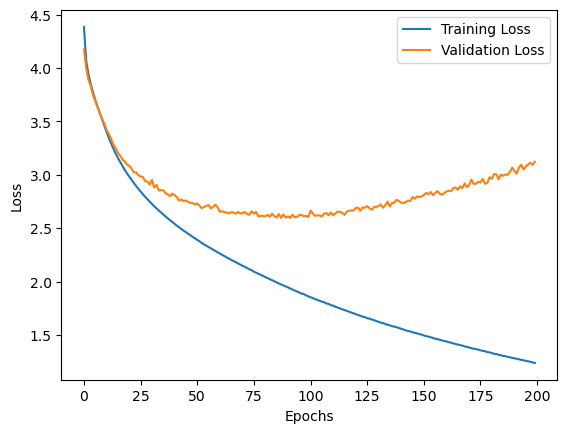

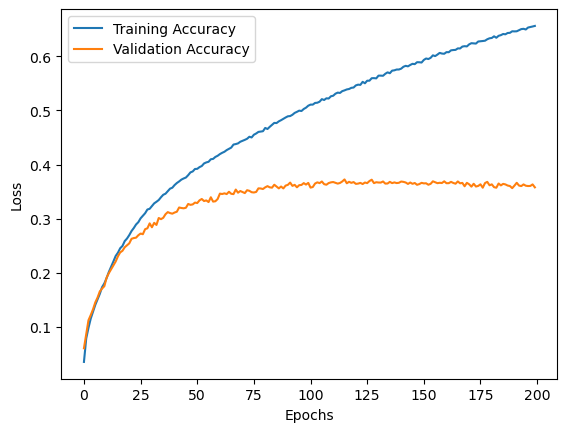

In [78]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [79]:
torch.save(model.state_dict(), 'model_weights.pth')

In [83]:
test_model(model, test_loader)

Test Accuracy: 35.9700


## 2c.1 CNN expermientation on other optimizers

In [85]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [89]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.1019, Training Accuracy: 0.2496
Epoch 9/100, Validation Loss: 3.1643, Validation Accuracy: 0.2376
Epoch 19/100, Training Loss: 2.7966, Training Accuracy: 0.3078
Epoch 19/100, Validation Loss: 2.9211, Validation Accuracy: 0.2897
Epoch 29/100, Training Loss: 2.5961, Training Accuracy: 0.3493
Epoch 29/100, Validation Loss: 2.7930, Validation Accuracy: 0.3044
Epoch 39/100, Training Loss: 2.4464, Training Accuracy: 0.3807
Epoch 39/100, Validation Loss: 2.7038, Validation Accuracy: 0.3290
Epoch 49/100, Training Loss: 2.3168, Training Accuracy: 0.4078
Epoch 49/100, Validation Loss: 2.6368, Validation Accuracy: 0.3441
Epoch 59/100, Training Loss: 2.2070, Training Accuracy: 0.4329
Epoch 59/100, Validation Loss: 2.6263, Validation Accuracy: 0.3455
Epoch 69/100, Training Loss: 2.1025, Training Accuracy: 0.4561
Epoch 69/100, Validation Loss: 2.5685, Validation Accuracy: 0.3576
Epoch 79/100, Training Loss: 2.0055, Training Accuracy: 0.4765
Epoch 79/100, Validation Loss

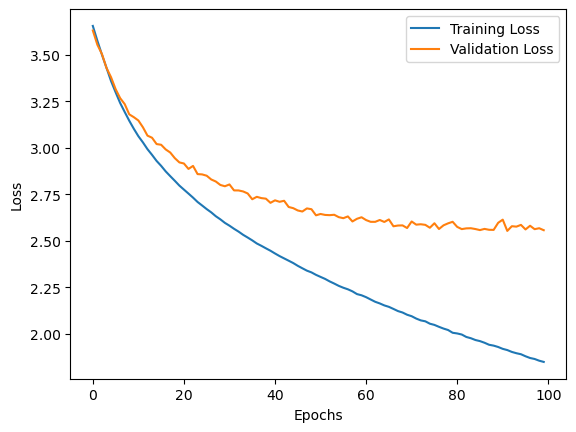

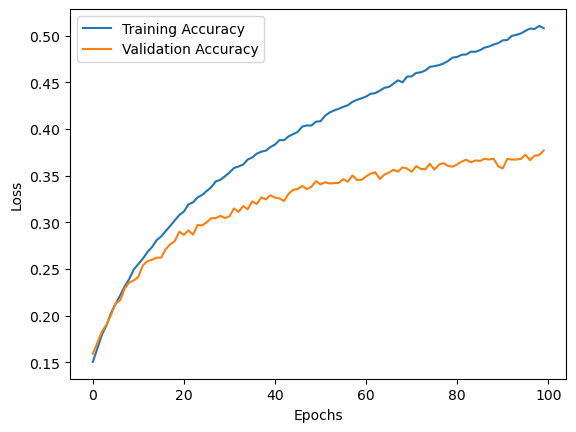

In [90]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [93]:
test_model(model, test_loader)

Test Accuracy: 37.6000%


In [94]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.SGD(model.parameters(),lr=1e-4)

In [95]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 4.6077, Training Accuracy: 0.0111
Epoch 9/100, Validation Loss: 4.6077, Validation Accuracy: 0.0111
Epoch 19/100, Training Loss: 4.6075, Training Accuracy: 0.0122
Epoch 19/100, Validation Loss: 4.6075, Validation Accuracy: 0.0124
Epoch 29/100, Training Loss: 4.6073, Training Accuracy: 0.0119
Epoch 29/100, Validation Loss: 4.6073, Validation Accuracy: 0.0108
Epoch 39/100, Training Loss: 4.6071, Training Accuracy: 0.0113
Epoch 39/100, Validation Loss: 4.6072, Validation Accuracy: 0.0112
Epoch 49/100, Training Loss: 4.6070, Training Accuracy: 0.0111
Epoch 49/100, Validation Loss: 4.6071, Validation Accuracy: 0.0107
Epoch 59/100, Training Loss: 4.6068, Training Accuracy: 0.0110
Epoch 59/100, Validation Loss: 4.6069, Validation Accuracy: 0.0107
Epoch 69/100, Training Loss: 4.6067, Training Accuracy: 0.0113
Epoch 69/100, Validation Loss: 4.6068, Validation Accuracy: 0.0109
Epoch 79/100, Training Loss: 4.6066, Training Accuracy: 0.0115
Epoch 79/100, Validation Loss

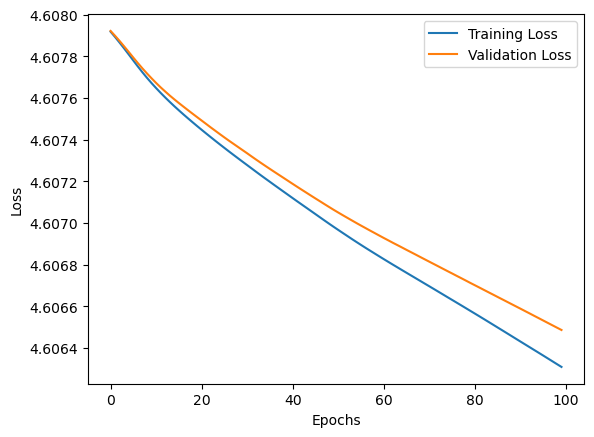

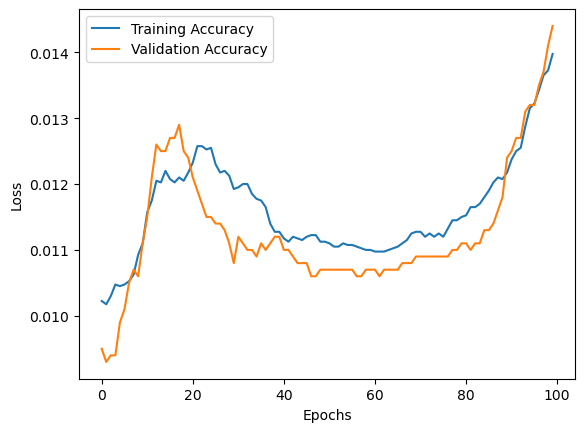

In [96]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

SDG optimizer show that training and validation loss is decreases but at extremely low rate suggesting that the model isn't sufficiently learning. Can be explore bit more with some adjustments to the optimizer SDG. Also, near end of epoch can see that the increase in a significantly rate suggesting that the model may have overfit

In [99]:

"""
Reguarding result on default values for each of the optimizer I'll take into future consideration at ADAMprop, and ADAgrad
at the moment explore experimentation of CNN architecture by increase size of channels to see the effects
"""


"\nReguarding result on default values for each of the optimizer I'll take into future consideration at ADAMprop, and ADAgrad\nat the moment explore experimentation of CNN architecture by increase size of channels to see the effects\n"

## 2c.2 Model Experimentation size of Conv2D layers channels to examine model behavior

In [114]:
# Increase number of channels 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        '''
        Increasing the out_channels examine whether the Conv2D layers will gain additional filters
        to learn vary features to see if can make accurate predictions of the images labels in
        the subtrain and validation datasets
        '''

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # increase from 32->64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # increase from 64->128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 16/2 = 8x8 channels 128 
        )
        # Input: 8x8x128
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((8 - 3 + 2(1) / 1) + 1 = 8x8  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4x4 channels 128
        )
        
        self.fc1 = nn.Sequential(
            # input size 4 * 4 * 128 = 2048
            nn.Linear(in_features=128 * 4 * 4, out_features=128),  
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=128, out_features=100)
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [115]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [116]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.9350, Training Accuracy: 0.2832
Epoch 9/100, Validation Loss: 3.0222, Validation Accuracy: 0.2603
Epoch 19/100, Training Loss: 2.4157, Training Accuracy: 0.3891
Epoch 19/100, Validation Loss: 2.7247, Validation Accuracy: 0.3248
Epoch 29/100, Training Loss: 2.0401, Training Accuracy: 0.4722
Epoch 29/100, Validation Loss: 2.5817, Validation Accuracy: 0.3652
Epoch 39/100, Training Loss: 1.7160, Training Accuracy: 0.5470
Epoch 39/100, Validation Loss: 2.5806, Validation Accuracy: 0.3752
Epoch 49/100, Training Loss: 1.4227, Training Accuracy: 0.6176
Epoch 49/100, Validation Loss: 2.7009, Validation Accuracy: 0.3808
Epoch 59/100, Training Loss: 1.1574, Training Accuracy: 0.6810
Epoch 59/100, Validation Loss: 2.8739, Validation Accuracy: 0.3804
Epoch 69/100, Training Loss: 0.9161, Training Accuracy: 0.7455
Epoch 69/100, Validation Loss: 3.1603, Validation Accuracy: 0.3732
Epoch 79/100, Training Loss: 0.6959, Training Accuracy: 0.8033
Epoch 79/100, Validation Loss

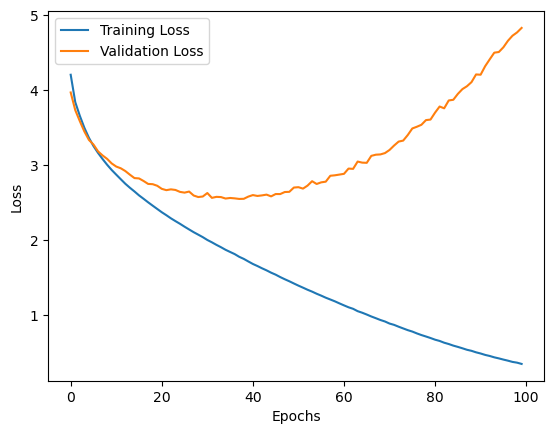

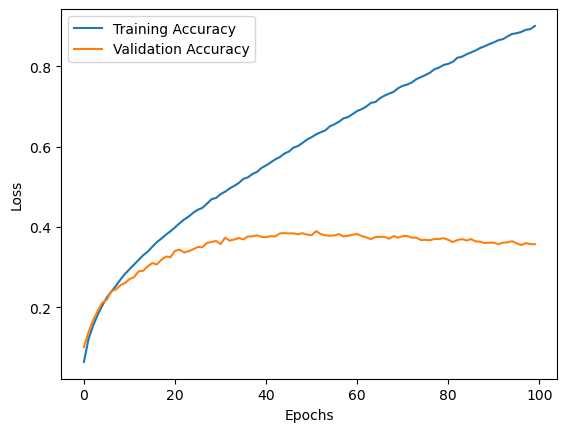

In [117]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# Increase out_channels seem suggest an model that is overfitting. 
# In regards with plot the training loss has a continues to decrease 
# While the validation loss trend start to increase after certain point 
# The Training Accuracy vs. Validation Accuracy shows similar trend the training accuracy keeps improving
# suggesting it is learning, yet the validation accuracy plateaus and slightly decrease suggesting a overfitting.
# Divergence gap shown from this graph supports this 

In [118]:
test_model(model, test_loader)

Test Accuracy: 35.6000%


In [119]:
torch.save({
    '2c-2model_state_dict': model.state_dict(),
    '2c-2optimizer_state_dict': optimizer.state_dict(),
}, '2c-2model_checkpoint.pth')

In [123]:
# Continue on exploring the channels by a slight decrease channels to see behavior of it. 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # keep increase 32->64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 16/2 = 8x8 channels 128 
        )
        # Input: 8x8x128
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((8 - 3 + 2(1) / 1) + 1 = 8x8  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 8/2 = 4x4 channels 128
        )
        
        self.fc1 = nn.Sequential(
            # input size 4 * 4 * 128 = 2048
            nn.Linear(in_features=128 * 4 * 4, out_features=128),  
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=128, out_features=100)
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [124]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [125]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.7101, Training Accuracy: 0.3270
Epoch 9/100, Validation Loss: 2.9270, Validation Accuracy: 0.2873
Epoch 19/100, Training Loss: 1.8569, Training Accuracy: 0.5112
Epoch 19/100, Validation Loss: 2.6810, Validation Accuracy: 0.3565
Epoch 29/100, Training Loss: 1.1386, Training Accuracy: 0.6844
Epoch 29/100, Validation Loss: 3.1712, Validation Accuracy: 0.3579
Epoch 39/100, Training Loss: 0.5512, Training Accuracy: 0.8359
Epoch 39/100, Validation Loss: 4.5769, Validation Accuracy: 0.3496
Epoch 49/100, Training Loss: 0.2386, Training Accuracy: 0.9229
Epoch 49/100, Validation Loss: 6.6700, Validation Accuracy: 0.3322
Epoch 59/100, Training Loss: 0.1450, Training Accuracy: 0.9515
Epoch 59/100, Validation Loss: 7.9732, Validation Accuracy: 0.3370
Epoch 69/100, Training Loss: 0.1102, Training Accuracy: 0.9650
Epoch 69/100, Validation Loss: 8.8373, Validation Accuracy: 0.3356
Epoch 79/100, Training Loss: 0.0904, Training Accuracy: 0.9714
Epoch 79/100, Validation Loss

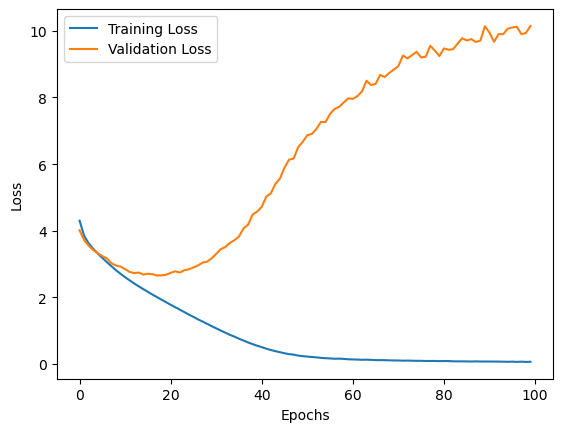

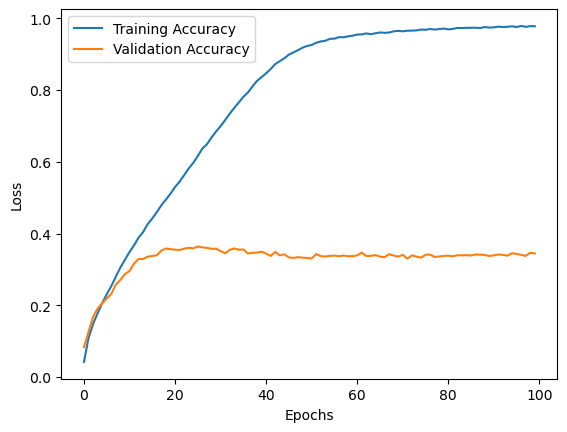

In [126]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

## 2c.3 Incorporates an simple Data Augmentation & reduction Model complexity

In [162]:
# Transformations to see if model can model generalize better
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # flip 
    transforms.RandomRotation(20), # rotates 20 degrees
    transforms.ToTensor(),
])

In [163]:
cifar100_train = dsets.CIFAR100(root='CIFAR100/', train=True, transform=transform, download=True)
cifar100_test = dsets.CIFAR100(root='CIFAR100/', train=False, transform=transforms.ToTensor(), download=True)
subtrain_dataset, validation_dataset = random_split(cifar100_train, [num_train, num_validate])

Files already downloaded and verified
Files already downloaded and verified


In [148]:
# Redection
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Removing layer3 Conv2D layer, while returning to same channels sizes 64->32, 128->64

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 64
            nn.Linear(in_features=64 * 8 * 8, out_features=64),  
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=64, out_features=100)
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [149]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [150]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.3958, Training Accuracy: 0.1918
Epoch 9/100, Validation Loss: 3.4077, Validation Accuracy: 0.1938
Epoch 19/100, Training Loss: 3.0046, Training Accuracy: 0.2685
Epoch 19/100, Validation Loss: 3.0688, Validation Accuracy: 0.2564
Epoch 29/100, Training Loss: 2.7104, Training Accuracy: 0.3244
Epoch 29/100, Validation Loss: 2.8353, Validation Accuracy: 0.2975
Epoch 39/100, Training Loss: 2.5140, Training Accuracy: 0.3679
Epoch 39/100, Validation Loss: 2.6863, Validation Accuracy: 0.3342
Epoch 49/100, Training Loss: 2.3626, Training Accuracy: 0.3959
Epoch 49/100, Validation Loss: 2.6049, Validation Accuracy: 0.3511
Epoch 59/100, Training Loss: 2.2377, Training Accuracy: 0.4239
Epoch 59/100, Validation Loss: 2.5394, Validation Accuracy: 0.3658
Epoch 69/100, Training Loss: 2.1354, Training Accuracy: 0.4468
Epoch 69/100, Validation Loss: 2.4911, Validation Accuracy: 0.3816
Epoch 79/100, Training Loss: 2.0456, Training Accuracy: 0.4665
Epoch 79/100, Validation Loss

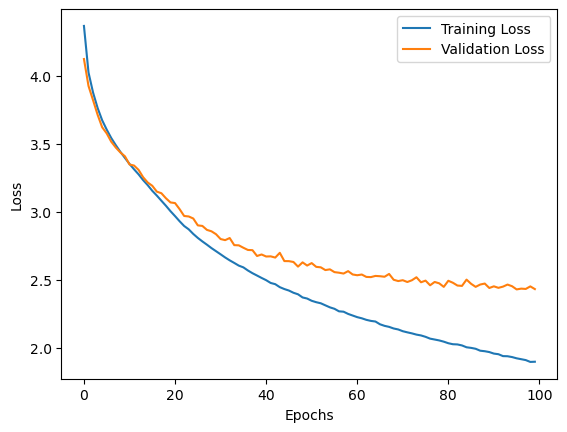

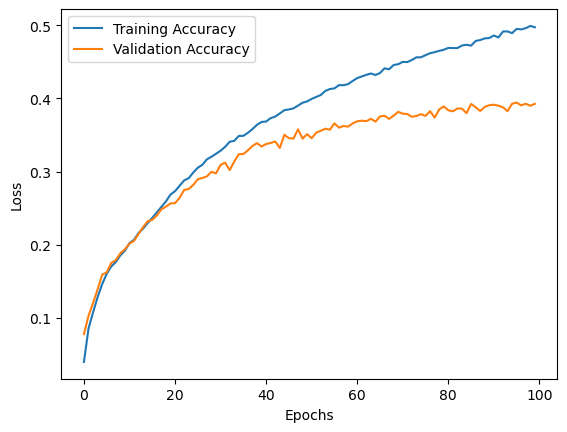

In [151]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# Model seem improve from the new additions model continues to learning
# while the increase rate of the validation loss is absent but plateau 
# may suggest overfitting may had begin

In [152]:
test_model(model, test_loader)

Test Accuracy: 42.3300%


In [153]:
torch.save({
    '2c-3model_state_dict': model.state_dict(),
    '2c-3optimizer_state_dict': optimizer.state_dict(),
}, '2c-3model_checkpoint.pth')

### 2c.3 Incorprate dropout layers

# Best model for model 3

In [154]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=128 * 8 * 8, out_features=64),  
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Linear(in_features=64, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [155]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [156]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.4879, Training Accuracy: 0.1684
Epoch 9/100, Validation Loss: 3.2885, Validation Accuracy: 0.2118
Epoch 19/100, Training Loss: 3.0903, Training Accuracy: 0.2409
Epoch 19/100, Validation Loss: 2.9361, Validation Accuracy: 0.2775
Epoch 29/100, Training Loss: 2.8519, Training Accuracy: 0.2863
Epoch 29/100, Validation Loss: 2.6763, Validation Accuracy: 0.3318
Epoch 39/100, Training Loss: 2.6766, Training Accuracy: 0.3219
Epoch 39/100, Validation Loss: 2.5615, Validation Accuracy: 0.3525
Epoch 49/100, Training Loss: 2.5276, Training Accuracy: 0.3487
Epoch 49/100, Validation Loss: 2.4223, Validation Accuracy: 0.3772
Epoch 59/100, Training Loss: 2.4015, Training Accuracy: 0.3762
Epoch 59/100, Validation Loss: 2.3820, Validation Accuracy: 0.3936
Epoch 69/100, Training Loss: 2.2819, Training Accuracy: 0.4030
Epoch 69/100, Validation Loss: 2.2778, Validation Accuracy: 0.4113
Epoch 79/100, Training Loss: 2.1981, Training Accuracy: 0.4181
Epoch 79/100, Validation Loss

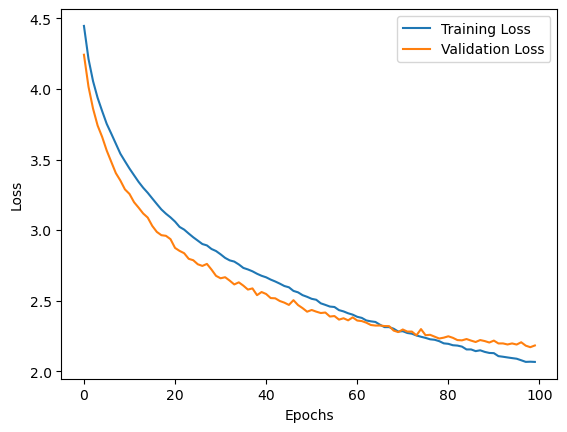

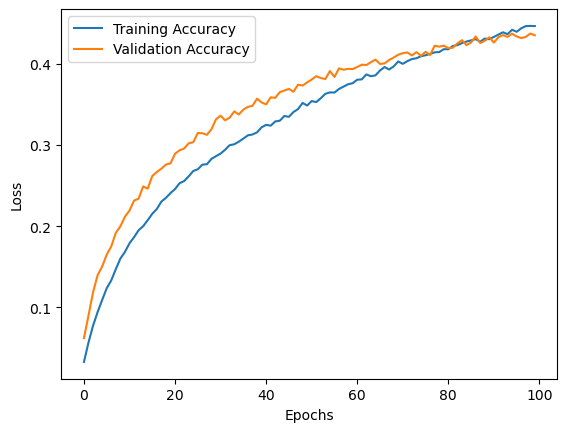

In [157]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [158]:
test_model(model, test_loader)

Test Accuracy: 45.7700%


In [244]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=128 * 8 * 8, out_features=64),  
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Linear(in_features=64, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [245]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4, alpha=0.995)

In [246]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.3631, Training Accuracy: 0.1913
Epoch 9/100, Validation Loss: 3.2190, Validation Accuracy: 0.2293
Epoch 19/100, Training Loss: 2.9022, Training Accuracy: 0.2749
Epoch 19/100, Validation Loss: 2.8658, Validation Accuracy: 0.2962
Epoch 29/100, Training Loss: 2.5916, Training Accuracy: 0.3336
Epoch 29/100, Validation Loss: 2.6510, Validation Accuracy: 0.3342
Epoch 39/100, Training Loss: 2.3240, Training Accuracy: 0.3886
Epoch 39/100, Validation Loss: 2.5607, Validation Accuracy: 0.3521
Epoch 49/100, Training Loss: 2.0820, Training Accuracy: 0.4375
Epoch 49/100, Validation Loss: 2.5171, Validation Accuracy: 0.3720
Epoch 59/100, Training Loss: 1.8645, Training Accuracy: 0.4825
Epoch 59/100, Validation Loss: 2.5231, Validation Accuracy: 0.3776
Epoch 69/100, Training Loss: 1.6857, Training Accuracy: 0.5223
Epoch 69/100, Validation Loss: 2.5984, Validation Accuracy: 0.3736
Epoch 79/100, Training Loss: 1.5341, Training Accuracy: 0.5572
Epoch 79/100, Validation Loss

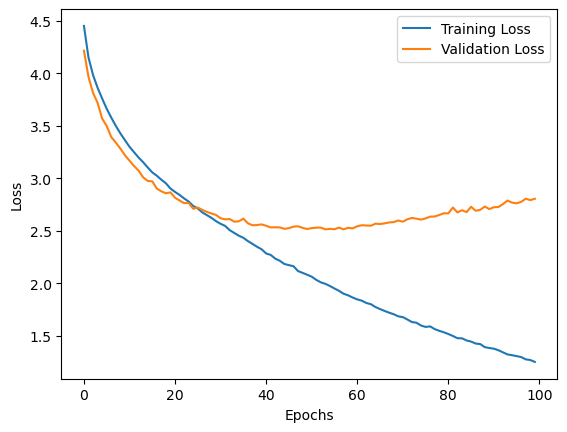

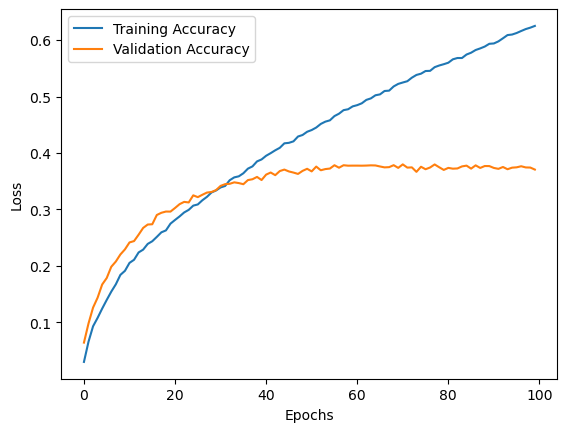

In [247]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

## Additonal nested conv2d layers

In [212]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=256 * 8 * 8, out_features=512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512, momentum=0.95)  # Batch normalization layer
        )
        self.fc2 = nn.Linear(in_features=512, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [213]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [215]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.0642, Training Accuracy: 0.4698
Epoch 9/100, Validation Loss: 2.2270, Validation Accuracy: 0.4306
Epoch 19/100, Training Loss: 1.4242, Training Accuracy: 0.6164
Epoch 19/100, Validation Loss: 2.0015, Validation Accuracy: 0.4769
Epoch 29/100, Training Loss: 1.0082, Training Accuracy: 0.7207
Epoch 29/100, Validation Loss: 2.0345, Validation Accuracy: 0.4862
Epoch 39/100, Training Loss: 0.7164, Training Accuracy: 0.7962
Epoch 39/100, Validation Loss: 2.0668, Validation Accuracy: 0.4927
Epoch 49/100, Training Loss: 0.5503, Training Accuracy: 0.8388
Epoch 49/100, Validation Loss: 2.1803, Validation Accuracy: 0.4886
Epoch 59/100, Training Loss: 0.4336, Training Accuracy: 0.8713
Epoch 59/100, Validation Loss: 2.2990, Validation Accuracy: 0.4971
Epoch 69/100, Training Loss: 0.3604, Training Accuracy: 0.8944
Epoch 69/100, Validation Loss: 2.4471, Validation Accuracy: 0.4997
Epoch 79/100, Training Loss: 0.3064, Training Accuracy: 0.9063
Epoch 79/100, Validation Loss

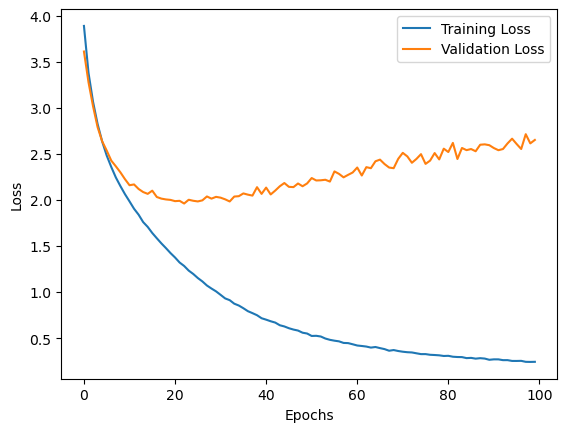

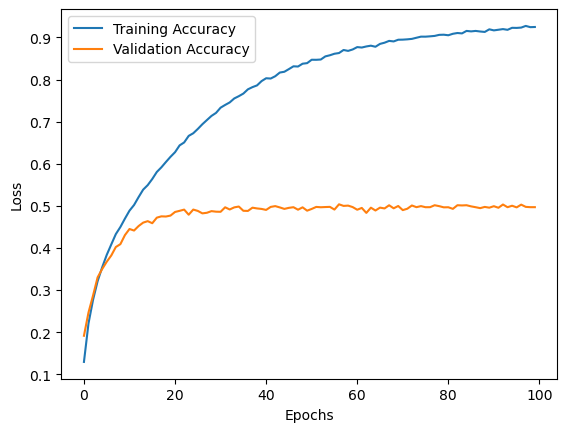

In [216]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [219]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=256 * 8 * 8, out_features=512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512, momentum=0.95)  # Batch normalization layer
        )
        self.fc2 = nn.Linear(in_features=512, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [220]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4, weight_decay=1e-5)

In [221]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 1.7849, Training Accuracy: 0.5339
Epoch 9/100, Validation Loss: 2.1100, Validation Accuracy: 0.4580
Epoch 19/100, Training Loss: 1.0819, Training Accuracy: 0.7087
Epoch 19/100, Validation Loss: 1.9529, Validation Accuracy: 0.4964
Epoch 29/100, Training Loss: 0.6962, Training Accuracy: 0.8058
Epoch 29/100, Validation Loss: 2.0656, Validation Accuracy: 0.4937
Epoch 39/100, Training Loss: 0.4991, Training Accuracy: 0.8565
Epoch 39/100, Validation Loss: 2.2352, Validation Accuracy: 0.4866
Epoch 49/100, Training Loss: 0.3809, Training Accuracy: 0.8889
Epoch 49/100, Validation Loss: 2.2784, Validation Accuracy: 0.4951
Epoch 59/100, Training Loss: 0.3168, Training Accuracy: 0.9053
Epoch 59/100, Validation Loss: 2.3854, Validation Accuracy: 0.4863
Epoch 69/100, Training Loss: 0.2777, Training Accuracy: 0.9161
Epoch 69/100, Validation Loss: 2.5353, Validation Accuracy: 0.4943
Epoch 79/100, Training Loss: 0.2402, Training Accuracy: 0.9272
Epoch 79/100, Validation Loss

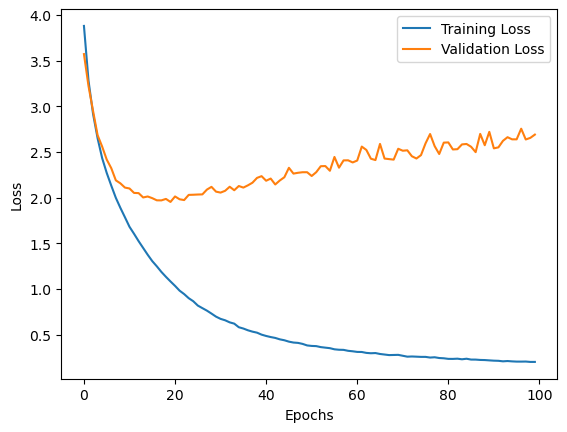

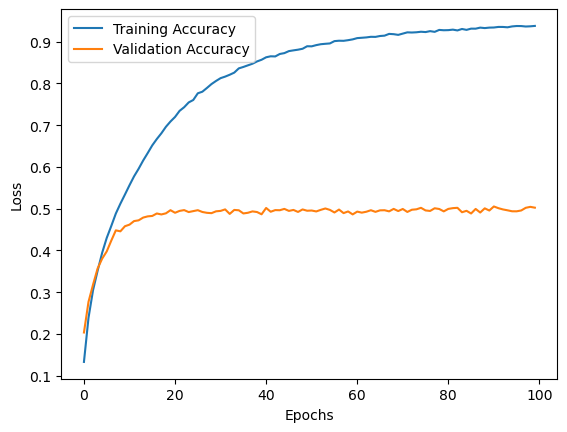

In [222]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

## Adjusting the pramaters of optimizer hyperpramaters

In [233]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=128 * 8 * 8, out_features=64),  
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Linear(in_features=64, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [ ]:
num_epochs = 30

In [234]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4, weight_decay=1e-6)

In [235]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.1598, Training Accuracy: 0.2276
Epoch 9/100, Validation Loss: 3.0328, Validation Accuracy: 0.2625
Epoch 19/100, Training Loss: 2.6373, Training Accuracy: 0.3280
Epoch 19/100, Validation Loss: 2.6858, Validation Accuracy: 0.3291
Epoch 29/100, Training Loss: 2.2715, Training Accuracy: 0.4010
Epoch 29/100, Validation Loss: 2.5571, Validation Accuracy: 0.3587
Epoch 39/100, Training Loss: 1.9800, Training Accuracy: 0.4589
Epoch 39/100, Validation Loss: 2.5077, Validation Accuracy: 0.3768
Epoch 49/100, Training Loss: 1.7503, Training Accuracy: 0.5103
Epoch 49/100, Validation Loss: 2.5422, Validation Accuracy: 0.3789
Epoch 59/100, Training Loss: 1.5634, Training Accuracy: 0.5554
Epoch 59/100, Validation Loss: 2.6235, Validation Accuracy: 0.3794
Epoch 69/100, Training Loss: 1.4165, Training Accuracy: 0.5845
Epoch 69/100, Validation Loss: 2.7000, Validation Accuracy: 0.3764
Epoch 79/100, Training Loss: 1.2974, Training Accuracy: 0.6122
Epoch 79/100, Validation Loss

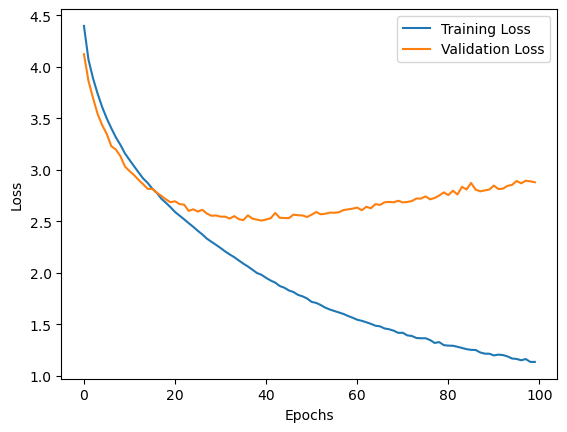

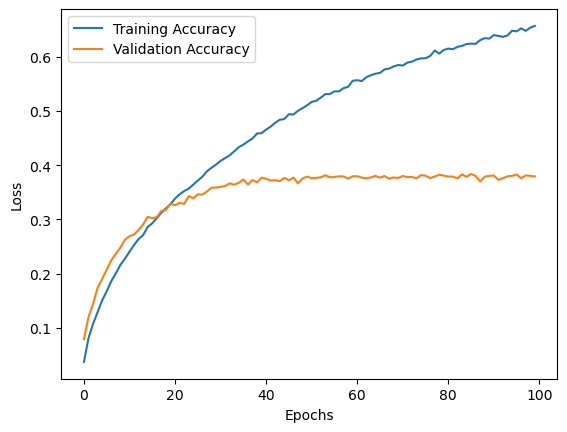

In [238]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [171]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=256 * 8 * 8, out_features=512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512, momentum=0.95, eps=0.005)  # Batch normalization layer
        )
        self.fc2 = nn.Linear(in_features=512, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [172]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [173]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 1.9928, Training Accuracy: 0.4859
Epoch 9/100, Validation Loss: 2.2211, Validation Accuracy: 0.4273
Epoch 19/100, Training Loss: 1.2413, Training Accuracy: 0.6645
Epoch 19/100, Validation Loss: 2.0241, Validation Accuracy: 0.4814
Epoch 29/100, Training Loss: 0.7923, Training Accuracy: 0.7801
Epoch 29/100, Validation Loss: 2.0879, Validation Accuracy: 0.4914
Epoch 39/100, Training Loss: 0.5403, Training Accuracy: 0.8452
Epoch 39/100, Validation Loss: 2.2057, Validation Accuracy: 0.5013
Epoch 49/100, Training Loss: 0.3900, Training Accuracy: 0.8867
Epoch 49/100, Validation Loss: 2.2978, Validation Accuracy: 0.4986
Epoch 59/100, Training Loss: 0.3093, Training Accuracy: 0.9083
Epoch 59/100, Validation Loss: 2.4831, Validation Accuracy: 0.4968
Epoch 69/100, Training Loss: 0.2575, Training Accuracy: 0.9236
Epoch 69/100, Validation Loss: 2.6005, Validation Accuracy: 0.4983
Epoch 79/100, Training Loss: 0.2216, Training Accuracy: 0.9331
Epoch 79/100, Validation Loss

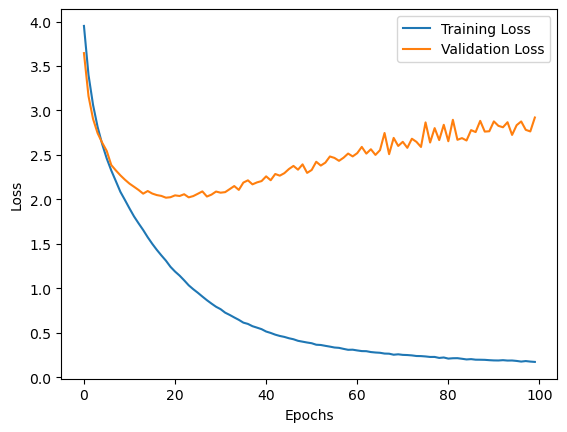

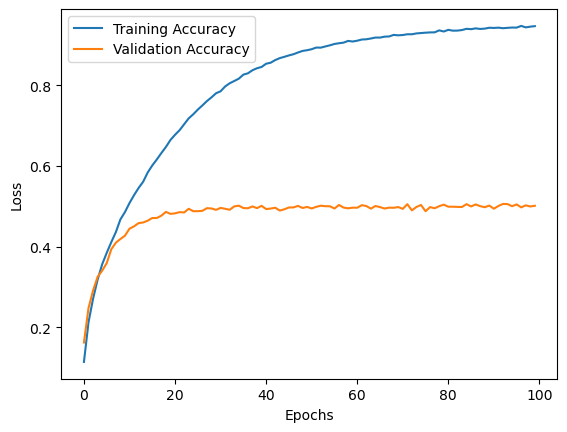

In [174]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [175]:
test_model(model, test_loader)

Test Accuracy: 53.0800%


In [181]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=256 * 8 * 8, out_features=512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512, momentum=0.95, eps=0.005)  # Batch normalization layer
        )
        self.fc2 = nn.Linear(in_features=512, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [182]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

In [183]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 1.7215, Training Accuracy: 0.5444
Epoch 9/100, Validation Loss: 1.8648, Validation Accuracy: 0.5018
Epoch 19/100, Training Loss: 1.1905, Training Accuracy: 0.6685
Epoch 19/100, Validation Loss: 1.7177, Validation Accuracy: 0.5460
Epoch 29/100, Training Loss: 0.8769, Training Accuracy: 0.7506
Epoch 29/100, Validation Loss: 1.7075, Validation Accuracy: 0.5583
Epoch 39/100, Training Loss: 0.6726, Training Accuracy: 0.8046
Epoch 39/100, Validation Loss: 1.7807, Validation Accuracy: 0.5615
Epoch 49/100, Training Loss: 0.5274, Training Accuracy: 0.8409
Epoch 49/100, Validation Loss: 1.8308, Validation Accuracy: 0.5645
Epoch 59/100, Training Loss: 0.4368, Training Accuracy: 0.8676
Epoch 59/100, Validation Loss: 1.8384, Validation Accuracy: 0.5656
Epoch 69/100, Training Loss: 0.3645, Training Accuracy: 0.8884
Epoch 69/100, Validation Loss: 1.9539, Validation Accuracy: 0.5685
Epoch 79/100, Training Loss: 0.3146, Training Accuracy: 0.9020
Epoch 79/100, Validation Loss

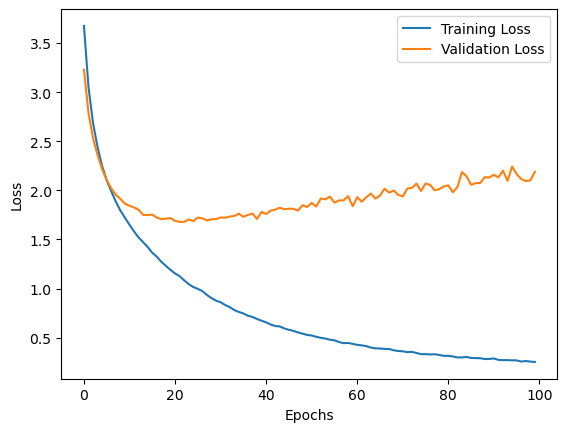

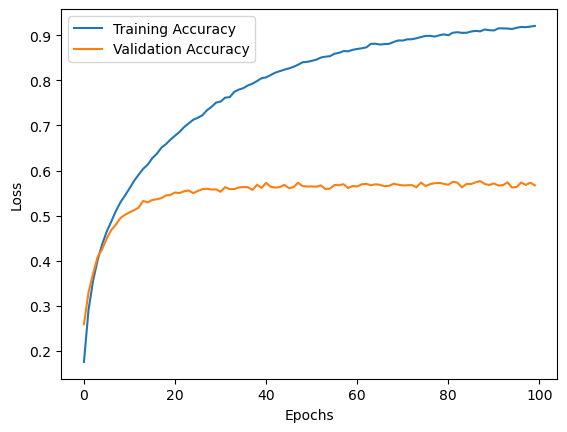

In [184]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [185]:
test_model(model, test_loader)

Test Accuracy: 60.0800%


In [186]:
torch.save({
    '2c-4model_state_dict': model.state_dict(),
    '2c-4optimizer_state_dict': optimizer.state_dict(),
}, '2c-4model_checkpoint.pth')

In [202]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1&2 addition to a dropout layers

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            # out_channels 32->64
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # ((32 - 3 + 2(1))/ 1) + 1 = 32x32   channels 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 32/2 = 16 width, height
        )
        # Input: 16x16x64
        self.layer2 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )

        # Input: 16x16x64
        self.layer3 = nn.Sequential(
            # outchannels 64->128
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # ((16 - 3 + 2(1) / 1) + 1 = 16x16  channels 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            # 16/2 = 8x8 channels 128 
        )


        self.fc1 = nn.Sequential(
            # input size 8 * 8 * 128 = 2048
            nn.Linear(in_features=512 * 4 * 4, out_features=512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512)  # Batch normalization layer
        )
        self.fc2 = nn.Linear(in_features=512, out_features=100)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [203]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.RMSprop(model.parameters(),lr=1e-4)